# Final Notebook

# AI Academy Semester 2 Capstone



Last Date updated: 1/13/2023

Collaborators: C.Lineman

## Table of Contents

1. Background
2. Import Data and Data Cleaning
3. Encoding
4. Feature Engineering
5. Visualizations  
6. Modeling
       A.  Model Prep
       B.  Decision Tree
       C.  XGBoost
7. Conclusion

## Background

##### Business Case

Since Airbnb entered the rental property game, the market has never been the same. People are willing to spend a little more to stay in someone else apartment or house that they are renting to other. Airbnb has made it much more accessible to find these people and put them in contact with renters. Because of this, it is sometime hard to find the correct price for both hotels and property owners to find the best price to price their properties.

##### Scope

This study is to find the best model to predict the most competitive price to price a property owner's property. Major consisting features we will keep in mind are longitude and latitude to make sure the model knows that location is an important considering factor.

##### Purpose

The result of this report is to demonstrate that XGBoost is the best model to use when predicting the most competitive price to price a rental property. This information will help property owners maximize profits by knowing the best price to price their properties and allowing for the maximum probability to get their property rented more.

## Data Source

This study was produced using a single data source from kaggle about Airbnb propery information

Source: 
* Kaggle Airbnb Data Set (https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data?resource=download)
    
###### Airbnb Data Set

This data set contains the features host id, hostname, listing id, listing name, latitude and longitude of listing, the neighborhood, price, room type, minimum number of nights, number of reviews, last review date, reviews per month, availability, host listings and city. The data set is from 2020 and has 226030 entries. This data set is suitable for this study because its data from Airbnb who is a leader in the rental property market. The main limitation is how old the data set is and that there is a bias for location (New York City) and that there are substantially more hotel properties than any other property. 

### Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import math
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import r2_score
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeClassifier

In [3]:
# suppress futurewarnings from statistical packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.ticker as mticker
from tabulate import tabulate

#read data

zip_file = "Dataset/AB_US_2020.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("Dataset/unZipped/")
        print("Extracted all")
except:
    print("Invalid file")
    
airbnbDS = pd.read_csv("Dataset/unZipped/AB_US_2020.csv")

Extracted all


C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Going to drop neighbourhood_group because of half of the values are null. For both name and host name I will fill the empty slots with "N/A", there is very few missing and I do not think name will be very important to regesion on price. For all null values in reviews_per_month will be replaced with 0. 

In [4]:
airbnbDS = airbnbDS.drop("neighbourhood_group", axis = 1)


airbnbDS = airbnbDS.fillna(value= {'name': 'N/A', 'host_name':'N/A', 'reviews_per_month': 0})

airbnbDS = airbnbDS.dropna()

### Encoding

This is to turn categorical data into numerical data so the model can us it better in its prediction

This is to help the model identify room type in its prediction

In [5]:
room_ID_dic = {'Entire home/apt': 1, 'Private room': 2,'Shared room': 3, 'Hotel room': 4}

airbnbDS['room_type_ID'] = airbnbDS['room_type'].apply(lambda x: room_ID_dic[x])

This is ot help the model identify city in its prediction

In [6]:
city_ID_dic = {'Asheville' : 1, 'Austin' : 2, 'Boston' :3, 'Broward County' :4, 'Cambridge':5,
       'Chicago':6, 'Clark County':7, 'Columbus':8, 'Denver':9, 'Hawaii':10,
       'Jersey City':11, 'Los Angeles':12, 'Nashville':13, 'New Orleans':14,
       'New York City':15, 'Oakland':16, 'Pacific Grove':17, 'Portland':18,
       'Rhode Island':19, 'Salem':20, 'San Clara Country':21, 'San Diego':22,
       'San Francisco':23, 'San Mateo County':24, 'Santa Cruz County':25,
       'Seattle':26, 'Twin Cities MSA':27, 'Washington D.C.':28}


airbnbDS['city_ID'] = airbnbDS['city'].apply(lambda x: city_ID_dic[x])

### Feature Engineering 
At first I only had feature engineering for my XGBoost, but then I decided that was not fair to base my second model with factors that would improve it and not allow the first model to reap the same benefits. I believed this allowed for biasy in my final decision so I moved my feature engineering to my cleaning potion of my notebook.

Profit for the dataset could greatly help predict the best price by region in our model

In [7]:
airbnbDS["Profit"] = airbnbDS['price'] * (airbnbDS['availability_365'])

The number of days since last review will help quantify the data and allow for the model to better predict our value.

In [8]:
airbnbDS['last_review'] = pd.to_datetime(airbnbDS['last_review'])

airbnbDS['days_since_last_review'] = datetime.now() - airbnbDS['last_review']

airbnbDS['days_since_last_review'] = airbnbDS['days_since_last_review'].dt.days

airbnbDS = airbnbDS.drop('last_review', axis =1)

### Visualizations
I got ideas for visualizations from Javan Ng (https://www.kaggle.com/code/javanng/airbnb-data-exploration-and-visualisation) 

Word cloud to show the most frequently used words in the description name

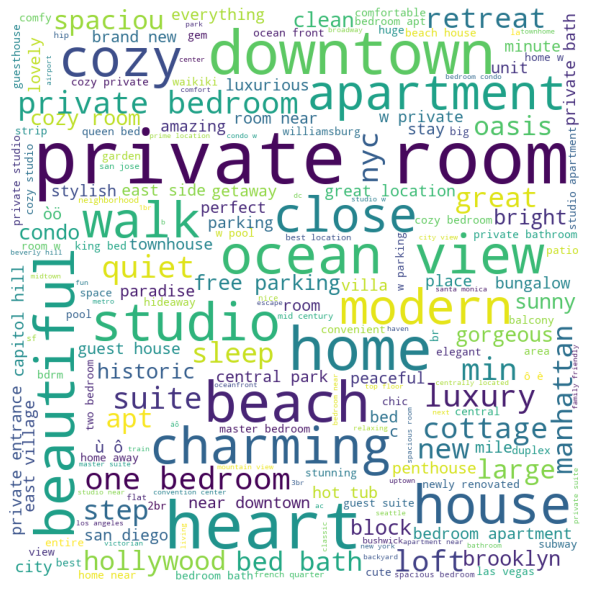

In [9]:
comment = ''
stopwords = set(STOPWORDS)

for i in airbnbDS['name']:
    i = str(i)
    
    tocken = i.split()
    
    for j in range(len(tocken)):
        tocken[j] = tocken[j].lower()
        
    comment += " ".join(tocken)+ " "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment)
                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Heat map to see if there is any correlations between price and all other numberic columns

In [10]:
airbnbDS.corr()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_ID,city_ID,Profit,days_since_last_review
id,1.000000,0.540372,-0.038278,0.014312,0.017370,-0.001539,-0.368653,0.072170,0.076238,-0.029554,0.001836,-0.075898,0.006527,-0.356766
host_id,0.540372,1.000000,-0.042855,0.020033,0.005994,-0.002218,-0.177309,0.078894,-0.029259,0.029986,0.062315,-0.072053,0.009021,-0.211447
latitude,-0.038278,-0.042855,1.000000,0.558152,-0.058386,0.000711,0.050037,0.053906,-0.203682,-0.177410,0.138919,0.448815,-0.100235,0.119590
longitude,0.014312,0.020033,0.558152,1.000000,-0.049598,-0.001756,-0.040210,-0.021908,-0.213236,-0.148488,0.112847,-0.046814,-0.078700,0.126213
price,0.017370,0.005994,-0.058386,-0.049598,1.000000,-0.000642,-0.060874,-0.055226,0.076714,0.047300,-0.122937,-0.004054,0.701144,0.002119
minimum_nights,-0.001539,-0.002218,0.000711,-0.001756,-0.000642,1.000000,-0.001247,-0.001790,-0.000738,-0.002710,0.002822,0.003087,-0.000868,0.005172
number_of_reviews,-0.368653,-0.177309,0.050037,-0.040210,-0.060874,-0.001247,1.000000,0.732273,-0.113825,0.068520,-0.039671,0.040011,-0.041179,-0.255399
reviews_per_month,0.072170,0.078894,0.053906,-0.021908,-0.055226,-0.001790,0.732273,1.000000,-0.113099,0.043291,-0.074901,0.007045,-0.041754,-0.389714
calculated_host_listings_count,0.076238,-0.029259,-0.203682,-0.213236,0.076714,-0.000738,-0.113825,-0.113099,1.000000,0.132094,-0.089915,-0.032374,0.081964,-0.047839
availability_365,-0.029554,0.029986,-0.177410,-0.148488,0.047300,-0.002710,0.068520,0.043291,0.132094,1.000000,-0.025836,-0.081520,0.331318,-0.241980


<AxesSubplot:>

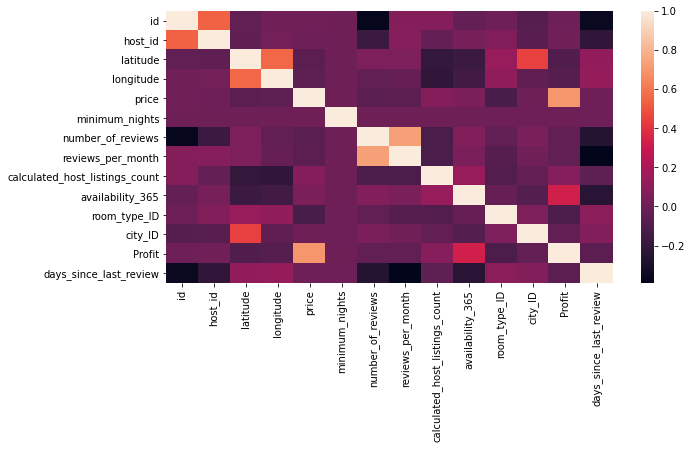

In [11]:
plt.figure(figsize = (10,5))
sns.heatmap(airbnbDS.corr())

Price does not have any correlations besides our self created column of price and a small correlation between room available. 

Showing prices compared to other categories

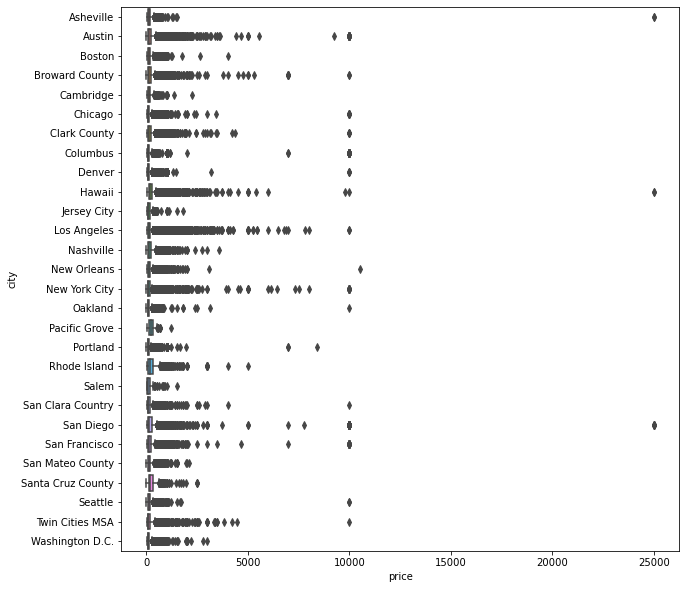

In [12]:
plt.figure(figsize = (10,10))
box_plot = sns.boxplot(x='price', y='city', 
                 data=airbnbDS)

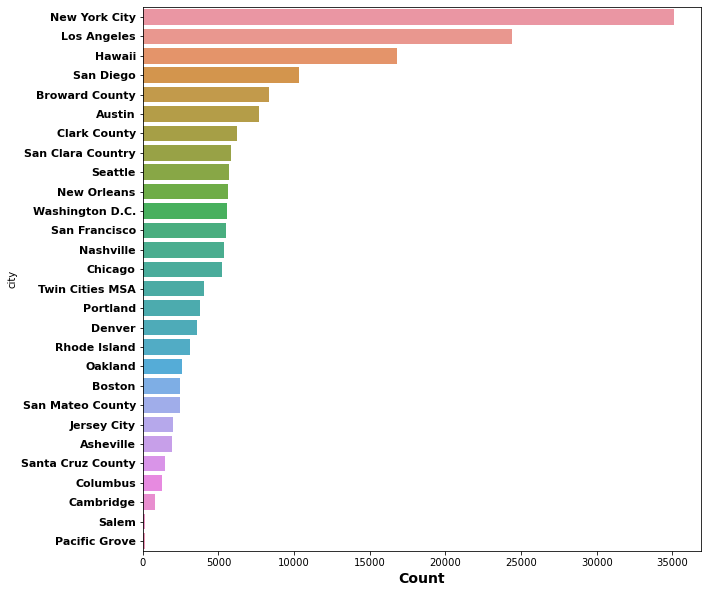

In [13]:
plt.figure(figsize = (10,10))
ax = sns.countplot(y=airbnbDS['city'],order=airbnbDS['city'].value_counts().index)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=11,fontweight='bold')
ax.set_xlabel('Count',fontsize=14,fontweight='bold')
plt.show()

This demonstrates that there is a large bias to New York in the data set

Showing Profit compared to other categories

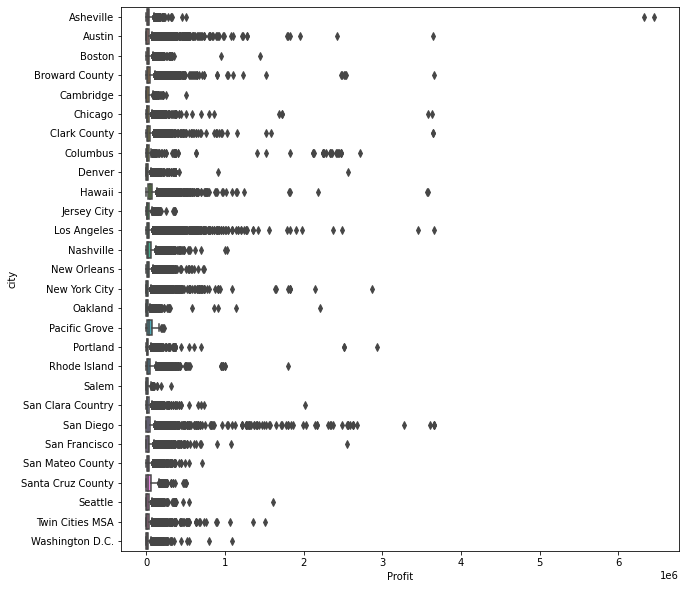

In [13]:
plt.figure(figsize = (10,10))
box_plot = sns.boxplot(x='Profit', y='city', 
                 data=airbnbDS)

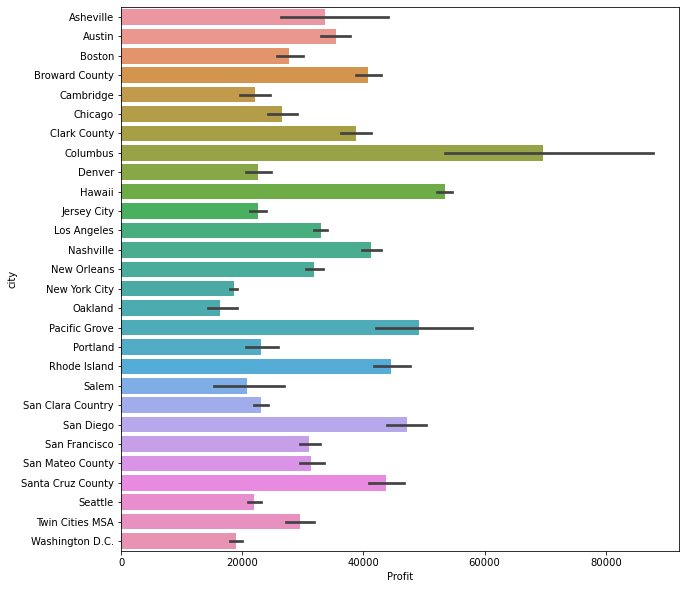

In [14]:
plt.figure(figsize = (10,10))
box_plot = sns.barplot(x='Profit', y='city', 
                 data=airbnbDS)

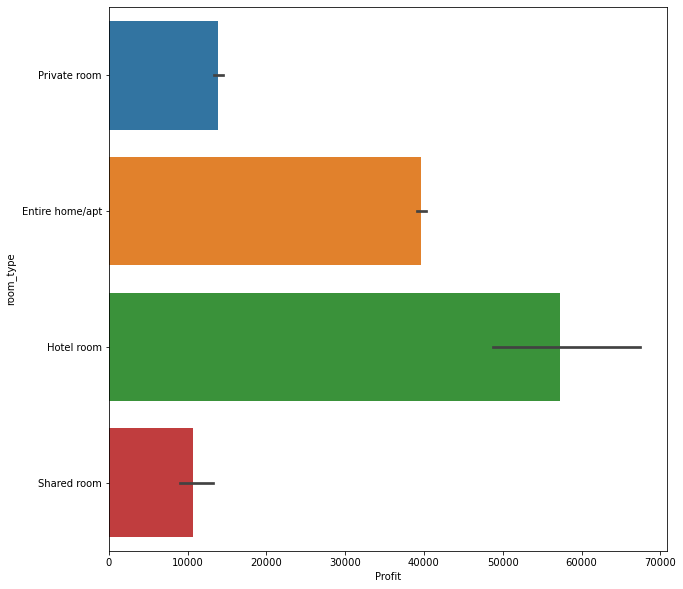

In [15]:
plt.figure(figsize = (10,10))
box_plot = sns.barplot(x='Profit', y='room_type', 
                 data=airbnbDS)

This demonstrates there is a large bias toward hotel rooms and entire homes/apt compared to shared rooms and private rooms.

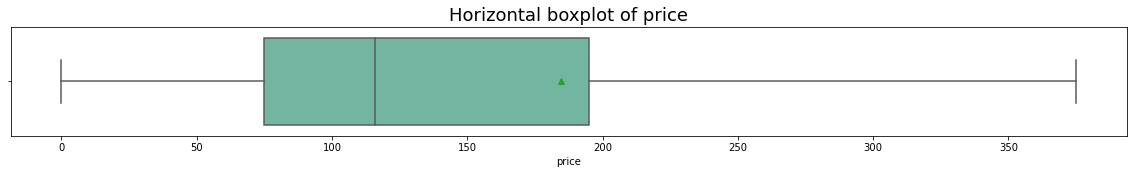

In [16]:
plt.figure(figsize=(20,2))
plt.title("Horizontal boxplot of price", size=18)
sns.boxplot(x="price", data=airbnbDS, showfliers = False, showmeans=True, palette="Set2")
plt.show()

The pricing data is fairly standard with no outliers

### Modeling

#### Model prep

Making copies of the clean data set into two panda frames that will be used for the differnt models.

Also, I am dropping ID, name, host_id, host_name, neighbourhood, room_type, and city because they are either categorical data or information that is irrelevant to the model. Name, host_name, neightbourhood, room_type, and city are all categorical data that I choose to remove, I encoded city and room_type so they can still be used in the model. ID and host_id is both numerical, but because they are ids this information will not help in the model, but only hurt it. So, I decided throw both of these columns out.

In [17]:
modelDS = airbnbDS.copy()
modelRF = airbnbDS.copy()

#removing the columns that we will not use in the model

modelDS = modelDS.drop('id', axis =1)
modelDS = modelDS.drop('name', axis =1)
modelDS = modelDS.drop('host_id', axis =1)
modelDS = modelDS.drop('host_name', axis =1)
modelDS = modelDS.drop('neighbourhood', axis =1)
modelDS = modelDS.drop('room_type', axis =1)
modelDS = modelDS.drop('city', axis =1)

modelRF = modelRF.drop('id', axis =1)
modelRF = modelRF.drop('name', axis =1)
modelRF = modelRF.drop('host_id', axis =1)
modelRF = modelRF.drop('host_name', axis =1)
modelRF = modelRF.drop('neighbourhood', axis =1)
modelRF = modelRF.drop('room_type', axis =1)
modelRF = modelRF.drop('city', axis =1)

#### Removing Outliers

In [18]:
lower_bound = .0
upper_bound = .95
modelDS = modelDS[modelDS['price'].between(modelDS['price'].quantile(lower_bound), \
            modelDS['price'].quantile(upper_bound), inclusive=True)].reset_index(drop=True)
modelRF = modelRF[modelRF['price'].between(modelRF['price'].quantile(lower_bound), \
            modelRF['price'].quantile(upper_bound), inclusive=True)].reset_index(drop=True)

#### Decision Tree

In [19]:
X = modelRF.drop('price', axis = 1)
y = modelRF['price']

scaler = StandardScaler()
X =scaler.fit_transform(X)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

rf_model = DecisionTreeRegressor()
rf_model.fit(X_train,y_train)
rf_model.score(X_test,y_test)

0.7261601958455389

In [20]:
SEED = 1
dt = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [21]:
y_true = np.array(y_test, dtype=np.float64)
y_pred = np.array(dt.predict(X_test), dtype=np.float64)
print("MSE Score: {:.4f}" .format(mean_squared_error(y_true, y_pred)))
print("RMSE Score: {:.4f}" .format(sqrt(mean_squared_error(y_true, y_pred))))

MSE Score: 2382.0976
RMSE Score: 48.8067


These are solid results and will be used as the baseline for the XGBoost

##### *** Running Box Below takes around 3.5 hours to load ***

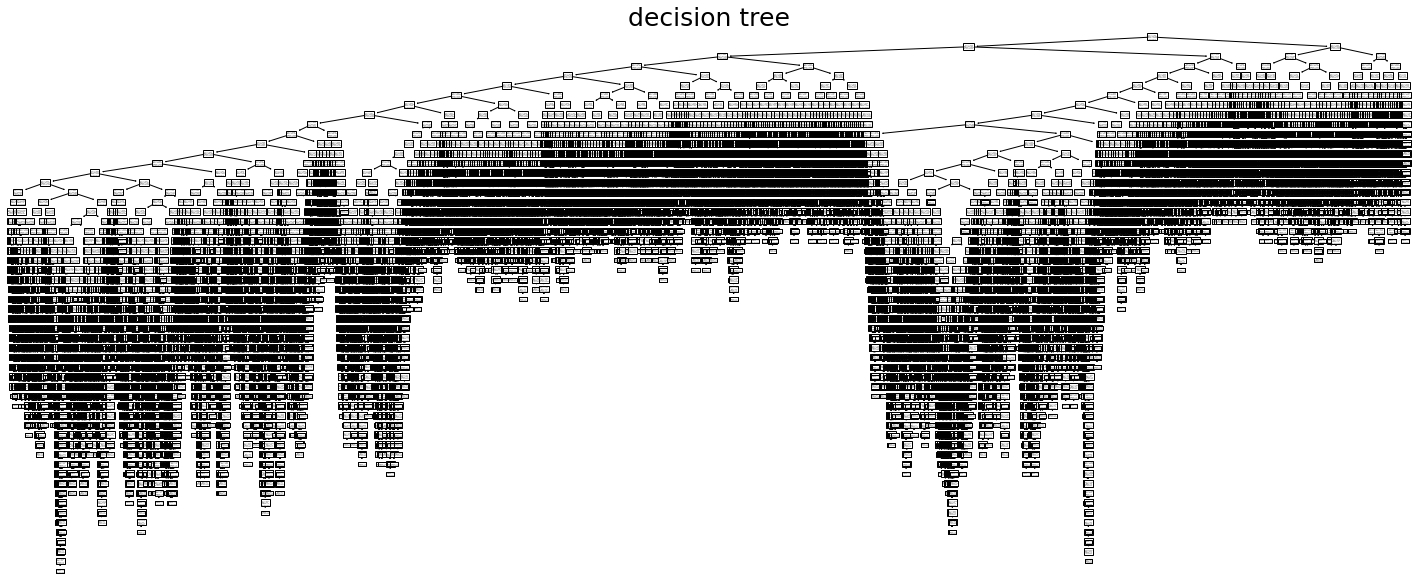

In [22]:
plt.figure(figsize = (25,10))
plot_tree(rf_model)

plt.show()

scatter plot to the correlations of the results

<AxesSubplot:>

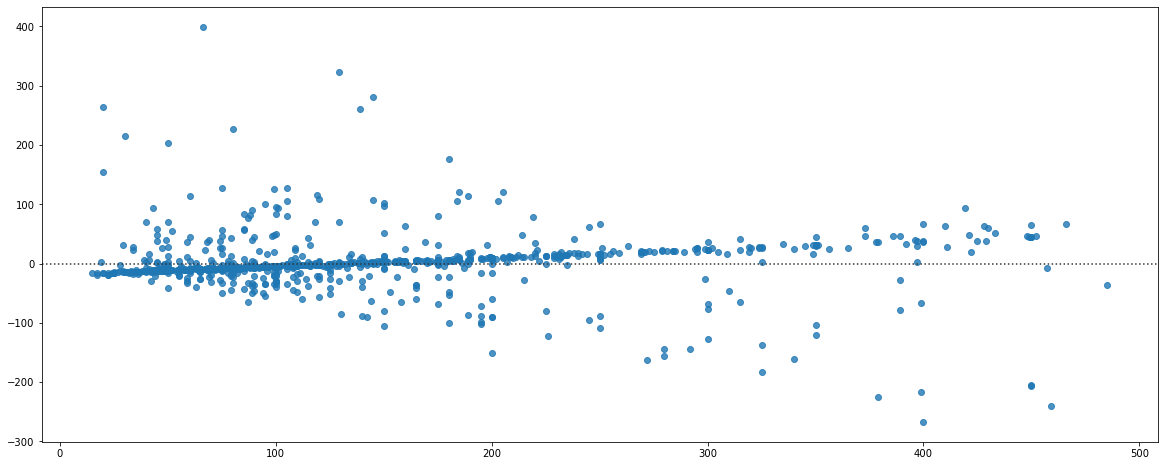

In [23]:
plt.figure(figsize=(20,8))
sns.residplot(x=y_test[:1000],y=y_pred[:1000])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00,
        0.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 4.0000e+00,
        6.0000e+00, 9.0000e+00, 5.0000e+00, 1.4000e+01, 6.0000e+00,
        7.0000e+00, 1.3000e+01, 1.1000e+01, 1.7000e+01, 2.1000e+01,
        2.2000e+01, 2.2000e+01, 1.7000e+01, 2.3000e+01, 2.5000e+01,
        2.3000e+01, 2.7000e+01, 4.6000e+01, 4.1000e+01, 4.7000e+01,
        4.6000e+01, 7.3000e+01, 6.0000e+01, 7.4000e+01, 8.9000e+01,
        8.7000e+01, 9.9000e+01, 1.3300e+02, 1.4500e+02, 1.1700e+02,
        2.1700e+02, 2.5300e+02, 2.6100e+02, 3.1100e+02, 4.0800e+02,
        6.0200e+02, 7.7900e+02, 1.2850e+03, 2.1379e+04, 2.5210e+03,
        8.7700e+02, 5.1800e+02, 4.6500e+02, 3.7800e+02, 3.0400e+02,
        2.4300e+02, 1.9700e+02, 1.8400e+02, 1.2000e+02, 1.0100e+02,
        1.2000e+02, 9.9000e+01, 6.6000e+01, 8.9000e+01, 6.2000e+01,
        3.9000e+01, 6.2000e+01, 3.5000e+01, 5.1000e+01, 2.4000e+01,
        2.8000e+01, 3.5000e+01, 3.2000e+01, 2.20

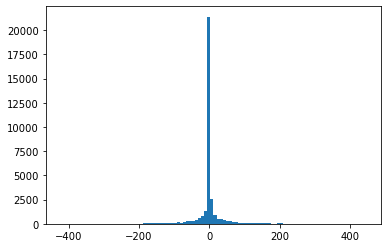

In [24]:
d=y_pred-y_test

plt.hist(d, bins=100)

#### XGBoost

In [27]:
X = modelDS.drop('price', axis = 1)
y = modelDS['price']

scaler = StandardScaler()
X =scaler.fit_transform(X)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

#Using validation to better show the accracy of my model
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state =20 )

xgModel = XGBRegressor()
xgModel.fit(X_train, y_train)
xgModel.score(X_test,y_test)

0.866797932075264

In [28]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_val, label = y_val)
dtest = xgb.DMatrix(X_test, label = y_test)

params = {'learning_rate': 0.001, 'max_depth':6}
model = xgb.train(params, dtrain,evals=[(dval, 'eval')], num_boost_round = 10000, early_stopping_rounds = 10)

[0]	eval-rmse:162.99585
Will train until eval-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:162.84778
[2]	eval-rmse:162.69957
[3]	eval-rmse:162.55165
[4]	eval-rmse:162.40392
[5]	eval-rmse:162.25630
[6]	eval-rmse:162.10866
[7]	eval-rmse:161.96162
[8]	eval-rmse:161.81429
[9]	eval-rmse:161.66762
[10]	eval-rmse:161.52068
[11]	eval-rmse:161.37413
[12]	eval-rmse:161.22760
[13]	eval-rmse:161.08128
[14]	eval-rmse:160.93520
[15]	eval-rmse:160.78920
[16]	eval-rmse:160.64325
[17]	eval-rmse:160.49760
[18]	eval-rmse:160.35204
[19]	eval-rmse:160.20674
[20]	eval-rmse:160.06152
[21]	eval-rmse:159.91649
[22]	eval-rmse:159.77150
[23]	eval-rmse:159.62676
[24]	eval-rmse:159.48236
[25]	eval-rmse:159.33781
[26]	eval-rmse:159.19351
[27]	eval-rmse:159.04944
[28]	eval-rmse:158.90547
[29]	eval-rmse:158.76170
[30]	eval-rmse:158.61789
[31]	eval-rmse:158.47440
[32]	eval-rmse:158.33105
[33]	eval-rmse:158.18779
[34]	eval-rmse:158.04472
[35]	eval-rmse:157.90195
[36]	eval-rmse:157.75900
[37]	eval-rmse:157.61662
[38

[318]	eval-rmse:123.04466
[319]	eval-rmse:122.93937
[320]	eval-rmse:122.83514
[321]	eval-rmse:122.72977
[322]	eval-rmse:122.62455
[323]	eval-rmse:122.52001
[324]	eval-rmse:122.41522
[325]	eval-rmse:122.31042
[326]	eval-rmse:122.20684
[327]	eval-rmse:122.10235
[328]	eval-rmse:121.99782
[329]	eval-rmse:121.89475
[330]	eval-rmse:121.79056
[331]	eval-rmse:121.68660
[332]	eval-rmse:121.58388
[333]	eval-rmse:121.47987
[334]	eval-rmse:121.37595
[335]	eval-rmse:121.27322
[336]	eval-rmse:121.16957
[337]	eval-rmse:121.06735
[338]	eval-rmse:120.96397
[339]	eval-rmse:120.86067
[340]	eval-rmse:120.75889
[341]	eval-rmse:120.65585
[342]	eval-rmse:120.55297
[343]	eval-rmse:120.45094
[344]	eval-rmse:120.34832
[345]	eval-rmse:120.24705
[346]	eval-rmse:120.14445
[347]	eval-rmse:120.04220
[348]	eval-rmse:119.93992
[349]	eval-rmse:119.83911
[350]	eval-rmse:119.73708
[351]	eval-rmse:119.63633
[352]	eval-rmse:119.53462
[353]	eval-rmse:119.43293
[354]	eval-rmse:119.33234
[355]	eval-rmse:119.23082
[356]	eval-r

[636]	eval-rmse:94.85239
[637]	eval-rmse:94.77883
[638]	eval-rmse:94.70648
[639]	eval-rmse:94.63218
[640]	eval-rmse:94.55837
[641]	eval-rmse:94.48431
[642]	eval-rmse:94.41257
[643]	eval-rmse:94.33849
[644]	eval-rmse:94.26466
[645]	eval-rmse:94.19117
[646]	eval-rmse:94.11776
[647]	eval-rmse:94.04417
[648]	eval-rmse:93.97165
[649]	eval-rmse:93.90018
[650]	eval-rmse:93.82666
[651]	eval-rmse:93.75363
[652]	eval-rmse:93.68272
[653]	eval-rmse:93.61063
[654]	eval-rmse:93.53757
[655]	eval-rmse:93.46510
[656]	eval-rmse:93.39223
[657]	eval-rmse:93.31955
[658]	eval-rmse:93.24794
[659]	eval-rmse:93.17738
[660]	eval-rmse:93.10490
[661]	eval-rmse:93.03293
[662]	eval-rmse:92.96062
[663]	eval-rmse:92.88831
[664]	eval-rmse:92.81818
[665]	eval-rmse:92.74611
[666]	eval-rmse:92.67637
[667]	eval-rmse:92.60570
[668]	eval-rmse:92.53376
[669]	eval-rmse:92.46260
[670]	eval-rmse:92.39094
[671]	eval-rmse:92.31949
[672]	eval-rmse:92.24805
[673]	eval-rmse:92.17858
[674]	eval-rmse:92.10738
[675]	eval-rmse:92.03662


[964]	eval-rmse:74.76002
[965]	eval-rmse:74.70927
[966]	eval-rmse:74.65860
[967]	eval-rmse:74.60980
[968]	eval-rmse:74.55932
[969]	eval-rmse:74.51122
[970]	eval-rmse:74.46148
[971]	eval-rmse:74.41112
[972]	eval-rmse:74.36085
[973]	eval-rmse:74.31237
[974]	eval-rmse:74.26224
[975]	eval-rmse:74.21294
[976]	eval-rmse:74.16294
[977]	eval-rmse:74.11364
[978]	eval-rmse:74.06593
[979]	eval-rmse:74.01620
[980]	eval-rmse:73.96703
[981]	eval-rmse:73.91910
[982]	eval-rmse:73.86944
[983]	eval-rmse:73.81996
[984]	eval-rmse:73.77050
[985]	eval-rmse:73.72278
[986]	eval-rmse:73.67567
[987]	eval-rmse:73.62637
[988]	eval-rmse:73.57790
[989]	eval-rmse:73.52869
[990]	eval-rmse:73.47949
[991]	eval-rmse:73.43246
[992]	eval-rmse:73.38393
[993]	eval-rmse:73.33508
[994]	eval-rmse:73.28825
[995]	eval-rmse:73.23955
[996]	eval-rmse:73.19222
[997]	eval-rmse:73.14546
[998]	eval-rmse:73.09683
[999]	eval-rmse:73.04989
[1000]	eval-rmse:73.00133
[1001]	eval-rmse:72.95483
[1002]	eval-rmse:72.90642
[1003]	eval-rmse:72.86

[1281]	eval-rmse:61.69902
[1282]	eval-rmse:61.66605
[1283]	eval-rmse:61.63216
[1284]	eval-rmse:61.59837
[1285]	eval-rmse:61.56657
[1286]	eval-rmse:61.53325
[1287]	eval-rmse:61.49957
[1288]	eval-rmse:61.46668
[1289]	eval-rmse:61.43306
[1290]	eval-rmse:61.40105
[1291]	eval-rmse:61.36753
[1292]	eval-rmse:61.33444
[1293]	eval-rmse:61.30314
[1294]	eval-rmse:61.26981
[1295]	eval-rmse:61.23678
[1296]	eval-rmse:61.20443
[1297]	eval-rmse:61.17113
[1298]	eval-rmse:61.13867
[1299]	eval-rmse:61.10548
[1300]	eval-rmse:61.07241
[1301]	eval-rmse:61.04147
[1302]	eval-rmse:61.00849
[1303]	eval-rmse:60.97708
[1304]	eval-rmse:60.94445
[1305]	eval-rmse:60.91160
[1306]	eval-rmse:60.87913
[1307]	eval-rmse:60.84813
[1308]	eval-rmse:60.81542
[1309]	eval-rmse:60.78405
[1310]	eval-rmse:60.75133
[1311]	eval-rmse:60.72018
[1312]	eval-rmse:60.68763
[1313]	eval-rmse:60.65700
[1314]	eval-rmse:60.62472
[1315]	eval-rmse:60.59231
[1316]	eval-rmse:60.56071
[1317]	eval-rmse:60.52829
[1318]	eval-rmse:60.49601
[1319]	eval-

[1597]	eval-rmse:53.15554
[1598]	eval-rmse:53.13449
[1599]	eval-rmse:53.11298
[1600]	eval-rmse:53.09170
[1601]	eval-rmse:53.07052
[1602]	eval-rmse:53.04895
[1603]	eval-rmse:53.02808
[1604]	eval-rmse:53.00632
[1605]	eval-rmse:52.98470
[1606]	eval-rmse:52.96340
[1607]	eval-rmse:52.94161
[1608]	eval-rmse:52.92075
[1609]	eval-rmse:52.89941
[1610]	eval-rmse:52.87821
[1611]	eval-rmse:52.85653
[1612]	eval-rmse:52.83623
[1613]	eval-rmse:52.81480
[1614]	eval-rmse:52.79346
[1615]	eval-rmse:52.77271
[1616]	eval-rmse:52.75115
[1617]	eval-rmse:52.73014
[1618]	eval-rmse:52.70910
[1619]	eval-rmse:52.68868
[1620]	eval-rmse:52.66736
[1621]	eval-rmse:52.64624
[1622]	eval-rmse:52.62580
[1623]	eval-rmse:52.60485
[1624]	eval-rmse:52.58361
[1625]	eval-rmse:52.56392
[1626]	eval-rmse:52.54330
[1627]	eval-rmse:52.52218
[1628]	eval-rmse:52.50177
[1629]	eval-rmse:52.48105
[1630]	eval-rmse:52.46038
[1631]	eval-rmse:52.43979
[1632]	eval-rmse:52.41858
[1633]	eval-rmse:52.39860
[1634]	eval-rmse:52.37801
[1635]	eval-

[1913]	eval-rmse:47.65959
[1914]	eval-rmse:47.64611
[1915]	eval-rmse:47.63207
[1916]	eval-rmse:47.61859
[1917]	eval-rmse:47.60522
[1918]	eval-rmse:47.59120
[1919]	eval-rmse:47.57867
[1920]	eval-rmse:47.56477
[1921]	eval-rmse:47.55073
[1922]	eval-rmse:47.53743
[1923]	eval-rmse:47.52342
[1924]	eval-rmse:47.51023
[1925]	eval-rmse:47.49685
[1926]	eval-rmse:47.48299
[1927]	eval-rmse:47.46925
[1928]	eval-rmse:47.45535
[1929]	eval-rmse:47.44201
[1930]	eval-rmse:47.42820
[1931]	eval-rmse:47.41444
[1932]	eval-rmse:47.40127
[1933]	eval-rmse:47.38825
[1934]	eval-rmse:47.37534
[1935]	eval-rmse:47.36165
[1936]	eval-rmse:47.34853
[1937]	eval-rmse:47.33490
[1938]	eval-rmse:47.32126
[1939]	eval-rmse:47.30774
[1940]	eval-rmse:47.29558
[1941]	eval-rmse:47.28205
[1942]	eval-rmse:47.26846
[1943]	eval-rmse:47.25482
[1944]	eval-rmse:47.24189
[1945]	eval-rmse:47.22839
[1946]	eval-rmse:47.21591
[1947]	eval-rmse:47.20236
[1948]	eval-rmse:47.18882
[1949]	eval-rmse:47.17598
[1950]	eval-rmse:47.16249
[1951]	eval-

[2229]	eval-rmse:44.15977
[2230]	eval-rmse:44.15109
[2231]	eval-rmse:44.14326
[2232]	eval-rmse:44.13461
[2233]	eval-rmse:44.12552
[2234]	eval-rmse:44.11718
[2235]	eval-rmse:44.10870
[2236]	eval-rmse:44.10011
[2237]	eval-rmse:44.09163
[2238]	eval-rmse:44.08306
[2239]	eval-rmse:44.07455
[2240]	eval-rmse:44.06599
[2241]	eval-rmse:44.05756
[2242]	eval-rmse:44.04907
[2243]	eval-rmse:44.04008
[2244]	eval-rmse:44.03190
[2245]	eval-rmse:44.02353
[2246]	eval-rmse:44.01507
[2247]	eval-rmse:44.00676
[2248]	eval-rmse:43.99834
[2249]	eval-rmse:43.98994
[2250]	eval-rmse:43.98166
[2251]	eval-rmse:43.97360
[2252]	eval-rmse:43.96523
[2253]	eval-rmse:43.95699
[2254]	eval-rmse:43.94874
[2255]	eval-rmse:43.94051
[2256]	eval-rmse:43.93212
[2257]	eval-rmse:43.92385
[2258]	eval-rmse:43.91557
[2259]	eval-rmse:43.90730
[2260]	eval-rmse:43.89933
[2261]	eval-rmse:43.89120
[2262]	eval-rmse:43.88297
[2263]	eval-rmse:43.87485
[2264]	eval-rmse:43.86674
[2265]	eval-rmse:43.85857
[2266]	eval-rmse:43.85073
[2267]	eval-

[2545]	eval-rmse:41.87323
[2546]	eval-rmse:41.86721
[2547]	eval-rmse:41.86164
[2548]	eval-rmse:41.85563
[2549]	eval-rmse:41.84951
[2550]	eval-rmse:41.84339
[2551]	eval-rmse:41.83789
[2552]	eval-rmse:41.83240
[2553]	eval-rmse:41.82628
[2554]	eval-rmse:41.82059
[2555]	eval-rmse:41.81480
[2556]	eval-rmse:41.80827
[2557]	eval-rmse:41.80221
[2558]	eval-rmse:41.79689
[2559]	eval-rmse:41.79146
[2560]	eval-rmse:41.78479
[2561]	eval-rmse:41.77939
[2562]	eval-rmse:41.77376
[2563]	eval-rmse:41.76802
[2564]	eval-rmse:41.76264
[2565]	eval-rmse:41.75666
[2566]	eval-rmse:41.75068
[2567]	eval-rmse:41.74481
[2568]	eval-rmse:41.73946
[2569]	eval-rmse:41.73425
[2570]	eval-rmse:41.72866
[2571]	eval-rmse:41.72273
[2572]	eval-rmse:41.71743
[2573]	eval-rmse:41.71212
[2574]	eval-rmse:41.70563
[2575]	eval-rmse:41.70031
[2576]	eval-rmse:41.69505
[2577]	eval-rmse:41.68925
[2578]	eval-rmse:41.68392
[2579]	eval-rmse:41.67864
[2580]	eval-rmse:41.67313
[2581]	eval-rmse:41.66790
[2582]	eval-rmse:41.66160
[2583]	eval-

[2861]	eval-rmse:40.26557
[2862]	eval-rmse:40.26209
[2863]	eval-rmse:40.25753
[2864]	eval-rmse:40.25355
[2865]	eval-rmse:40.24907
[2866]	eval-rmse:40.24479
[2867]	eval-rmse:40.24023
[2868]	eval-rmse:40.23569
[2869]	eval-rmse:40.23121
[2870]	eval-rmse:40.22695
[2871]	eval-rmse:40.22292
[2872]	eval-rmse:40.21849
[2873]	eval-rmse:40.21403
[2874]	eval-rmse:40.20952
[2875]	eval-rmse:40.20530
[2876]	eval-rmse:40.20114
[2877]	eval-rmse:40.19673
[2878]	eval-rmse:40.19282
[2879]	eval-rmse:40.18863
[2880]	eval-rmse:40.18461
[2881]	eval-rmse:40.18042
[2882]	eval-rmse:40.17623
[2883]	eval-rmse:40.17284
[2884]	eval-rmse:40.16866
[2885]	eval-rmse:40.16420
[2886]	eval-rmse:40.15979
[2887]	eval-rmse:40.15584
[2888]	eval-rmse:40.15171
[2889]	eval-rmse:40.14760
[2890]	eval-rmse:40.14345
[2891]	eval-rmse:40.13934
[2892]	eval-rmse:40.13493
[2893]	eval-rmse:40.13110
[2894]	eval-rmse:40.12773
[2895]	eval-rmse:40.12366
[2896]	eval-rmse:40.11929
[2897]	eval-rmse:40.11521
[2898]	eval-rmse:40.11090
[2899]	eval-

[3177]	eval-rmse:39.20281
[3178]	eval-rmse:39.19999
[3179]	eval-rmse:39.19714
[3180]	eval-rmse:39.19461
[3181]	eval-rmse:39.19235
[3182]	eval-rmse:39.18984
[3183]	eval-rmse:39.18700
[3184]	eval-rmse:39.18418
[3185]	eval-rmse:39.18166
[3186]	eval-rmse:39.17896
[3187]	eval-rmse:39.17671
[3188]	eval-rmse:39.17445
[3189]	eval-rmse:39.17170
[3190]	eval-rmse:39.16890
[3191]	eval-rmse:39.16623
[3192]	eval-rmse:39.16345
[3193]	eval-rmse:39.16054
[3194]	eval-rmse:39.15831
[3195]	eval-rmse:39.15554
[3196]	eval-rmse:39.15332
[3197]	eval-rmse:39.15085
[3198]	eval-rmse:39.14808
[3199]	eval-rmse:39.14536
[3200]	eval-rmse:39.14290
[3201]	eval-rmse:39.14025
[3202]	eval-rmse:39.13803
[3203]	eval-rmse:39.13479
[3204]	eval-rmse:39.13203
[3205]	eval-rmse:39.12928
[3206]	eval-rmse:39.12684
[3207]	eval-rmse:39.12422
[3208]	eval-rmse:39.12149
[3209]	eval-rmse:39.11906
[3210]	eval-rmse:39.11688
[3211]	eval-rmse:39.11424
[3212]	eval-rmse:39.11153
[3213]	eval-rmse:39.10910
[3214]	eval-rmse:39.10638
[3215]	eval-

[3493]	eval-rmse:38.45803
[3494]	eval-rmse:38.45619
[3495]	eval-rmse:38.45428
[3496]	eval-rmse:38.45251
[3497]	eval-rmse:38.45069
[3498]	eval-rmse:38.44891
[3499]	eval-rmse:38.44699
[3500]	eval-rmse:38.44518
[3501]	eval-rmse:38.44342
[3502]	eval-rmse:38.44157
[3503]	eval-rmse:38.43977
[3504]	eval-rmse:38.43795
[3505]	eval-rmse:38.43608
[3506]	eval-rmse:38.43433
[3507]	eval-rmse:38.43254
[3508]	eval-rmse:38.43070
[3509]	eval-rmse:38.42895
[3510]	eval-rmse:38.42707
[3511]	eval-rmse:38.42529
[3512]	eval-rmse:38.42357
[3513]	eval-rmse:38.42106
[3514]	eval-rmse:38.41919
[3515]	eval-rmse:38.41666
[3516]	eval-rmse:38.41415
[3517]	eval-rmse:38.41164
[3518]	eval-rmse:38.40982
[3519]	eval-rmse:38.40729
[3520]	eval-rmse:38.40480
[3521]	eval-rmse:38.40306
[3522]	eval-rmse:38.40036
[3523]	eval-rmse:38.39827
[3524]	eval-rmse:38.39577
[3525]	eval-rmse:38.39395
[3526]	eval-rmse:38.39127
[3527]	eval-rmse:38.38858
[3528]	eval-rmse:38.38608
[3529]	eval-rmse:38.38400
[3530]	eval-rmse:38.38132
[3531]	eval-

[3809]	eval-rmse:37.88921
[3810]	eval-rmse:37.88827
[3811]	eval-rmse:37.88623
[3812]	eval-rmse:37.88511
[3813]	eval-rmse:37.88299
[3814]	eval-rmse:37.88087
[3815]	eval-rmse:37.87876
[3816]	eval-rmse:37.87717
[3817]	eval-rmse:37.87624
[3818]	eval-rmse:37.87408
[3819]	eval-rmse:37.87297
[3820]	eval-rmse:37.87093
[3821]	eval-rmse:37.87001
[3822]	eval-rmse:37.86785
[3823]	eval-rmse:37.86647
[3824]	eval-rmse:37.86543
[3825]	eval-rmse:37.86333
[3826]	eval-rmse:37.86125
[3827]	eval-rmse:37.86018
[3828]	eval-rmse:37.85815
[3829]	eval-rmse:37.85721
[3830]	eval-rmse:37.85508
[3831]	eval-rmse:37.85300
[3832]	eval-rmse:37.85086
[3833]	eval-rmse:37.84986
[3834]	eval-rmse:37.84784
[3835]	eval-rmse:37.84633
[3836]	eval-rmse:37.84530
[3837]	eval-rmse:37.84267
[3838]	eval-rmse:37.84058
[3839]	eval-rmse:37.83798
[3840]	eval-rmse:37.83690
[3841]	eval-rmse:37.83428
[3842]	eval-rmse:37.83324
[3843]	eval-rmse:37.83124
[3844]	eval-rmse:37.82986
[3845]	eval-rmse:37.82860
[3846]	eval-rmse:37.82652
[3847]	eval-

[4125]	eval-rmse:37.33400
[4126]	eval-rmse:37.33235
[4127]	eval-rmse:37.33152
[4128]	eval-rmse:37.32991
[4129]	eval-rmse:37.32905
[4130]	eval-rmse:37.32674
[4131]	eval-rmse:37.32599
[4132]	eval-rmse:37.32438
[4133]	eval-rmse:37.32287
[4134]	eval-rmse:37.32200
[4135]	eval-rmse:37.31972
[4136]	eval-rmse:37.31870
[4137]	eval-rmse:37.31718
[4138]	eval-rmse:37.31633
[4139]	eval-rmse:37.31409
[4140]	eval-rmse:37.31336
[4141]	eval-rmse:37.31186
[4142]	eval-rmse:37.31089
[4143]	eval-rmse:37.30858
[4144]	eval-rmse:37.30786
[4145]	eval-rmse:37.30616
[4146]	eval-rmse:37.30394
[4147]	eval-rmse:37.30225
[4148]	eval-rmse:37.30064
[4149]	eval-rmse:37.29840
[4150]	eval-rmse:37.29754
[4151]	eval-rmse:37.29653
[4152]	eval-rmse:37.29500
[4153]	eval-rmse:37.29332
[4154]	eval-rmse:37.29106
[4155]	eval-rmse:37.29024
[4156]	eval-rmse:37.28873
[4157]	eval-rmse:37.28801
[4158]	eval-rmse:37.28578
[4159]	eval-rmse:37.28409
[4160]	eval-rmse:37.28251
[4161]	eval-rmse:37.28179
[4162]	eval-rmse:37.27959
[4163]	eval-

[4441]	eval-rmse:36.91405
[4442]	eval-rmse:36.91327
[4443]	eval-rmse:36.91234
[4444]	eval-rmse:36.91094
[4445]	eval-rmse:36.90886
[4446]	eval-rmse:36.90776
[4447]	eval-rmse:36.90682
[4448]	eval-rmse:36.90571
[4449]	eval-rmse:36.90442
[4450]	eval-rmse:36.90367
[4451]	eval-rmse:36.90278
[4452]	eval-rmse:36.90133
[4453]	eval-rmse:36.90029
[4454]	eval-rmse:36.89953
[4455]	eval-rmse:36.89811
[4456]	eval-rmse:36.89707
[4457]	eval-rmse:36.89635
[4458]	eval-rmse:36.89439
[4459]	eval-rmse:36.89351
[4460]	eval-rmse:36.89213
[4461]	eval-rmse:36.89100
[4462]	eval-rmse:36.89023
[4463]	eval-rmse:36.88932
[4464]	eval-rmse:36.88854
[4465]	eval-rmse:36.88710
[4466]	eval-rmse:36.88639
[4467]	eval-rmse:36.88444
[4468]	eval-rmse:36.88303
[4469]	eval-rmse:36.88179
[4470]	eval-rmse:36.87985
[4471]	eval-rmse:36.87913
[4472]	eval-rmse:36.87775
[4473]	eval-rmse:36.87581
[4474]	eval-rmse:36.87506
[4475]	eval-rmse:36.87301
[4476]	eval-rmse:36.87162
[4477]	eval-rmse:36.87027
[4478]	eval-rmse:36.86960
[4479]	eval-

[4757]	eval-rmse:36.60450
[4758]	eval-rmse:36.60377
[4759]	eval-rmse:36.60323
[4760]	eval-rmse:36.60246
[4761]	eval-rmse:36.60191
[4762]	eval-rmse:36.60116
[4763]	eval-rmse:36.60012
[4764]	eval-rmse:36.59951
[4765]	eval-rmse:36.59820
[4766]	eval-rmse:36.59765
[4767]	eval-rmse:36.59694
[4768]	eval-rmse:36.59594
[4769]	eval-rmse:36.59541
[4770]	eval-rmse:36.59465
[4771]	eval-rmse:36.59363
[4772]	eval-rmse:36.59309
[4773]	eval-rmse:36.59150
[4774]	eval-rmse:36.59079
[4775]	eval-rmse:36.59025
[4776]	eval-rmse:36.58928
[4777]	eval-rmse:36.58875
[4778]	eval-rmse:36.58800
[4779]	eval-rmse:36.58699
[4780]	eval-rmse:36.58646
[4781]	eval-rmse:36.58572
[4782]	eval-rmse:36.58521
[4783]	eval-rmse:36.58389
[4784]	eval-rmse:36.58315
[4785]	eval-rmse:36.58261
[4786]	eval-rmse:36.58188
[4787]	eval-rmse:36.58087
[4788]	eval-rmse:36.58025
[4789]	eval-rmse:36.57925
[4790]	eval-rmse:36.57863
[4791]	eval-rmse:36.57731
[4792]	eval-rmse:36.57668
[4793]	eval-rmse:36.57590
[4794]	eval-rmse:36.57490
[4795]	eval-

[5073]	eval-rmse:36.33207
[5074]	eval-rmse:36.33165
[5075]	eval-rmse:36.33102
[5076]	eval-rmse:36.32963
[5077]	eval-rmse:36.32892
[5078]	eval-rmse:36.32852
[5079]	eval-rmse:36.32786
[5080]	eval-rmse:36.32653
[5081]	eval-rmse:36.32611
[5082]	eval-rmse:36.32539
[5083]	eval-rmse:36.32410
[5084]	eval-rmse:36.32319
[5085]	eval-rmse:36.32279
[5086]	eval-rmse:36.32184
[5087]	eval-rmse:36.32146
[5088]	eval-rmse:36.32054
[5089]	eval-rmse:36.31992
[5090]	eval-rmse:36.31857
[5091]	eval-rmse:36.31820
[5092]	eval-rmse:36.31749
[5093]	eval-rmse:36.31707
[5094]	eval-rmse:36.31646
[5095]	eval-rmse:36.31517
[5096]	eval-rmse:36.31425
[5097]	eval-rmse:36.31385
[5098]	eval-rmse:36.31292
[5099]	eval-rmse:36.31207
[5100]	eval-rmse:36.31142
[5101]	eval-rmse:36.31071
[5102]	eval-rmse:36.31028
[5103]	eval-rmse:36.30960
[5104]	eval-rmse:36.30865
[5105]	eval-rmse:36.30828
[5106]	eval-rmse:36.30767
[5107]	eval-rmse:36.30697
[5108]	eval-rmse:36.30656
[5109]	eval-rmse:36.30530
[5110]	eval-rmse:36.30389
[5111]	eval-

[5389]	eval-rmse:36.13243
[5390]	eval-rmse:36.13159
[5391]	eval-rmse:36.13128
[5392]	eval-rmse:36.13080
[5393]	eval-rmse:36.13000
[5394]	eval-rmse:36.12976
[5395]	eval-rmse:36.12898
[5396]	eval-rmse:36.12839
[5397]	eval-rmse:36.12791
[5398]	eval-rmse:36.12709
[5399]	eval-rmse:36.12632
[5400]	eval-rmse:36.12600
[5401]	eval-rmse:36.12526
[5402]	eval-rmse:36.12497
[5403]	eval-rmse:36.12377
[5404]	eval-rmse:36.12345
[5405]	eval-rmse:36.12293
[5406]	eval-rmse:36.12260
[5407]	eval-rmse:36.12182
[5408]	eval-rmse:36.12108
[5409]	eval-rmse:36.12024
[5410]	eval-rmse:36.11967
[5411]	eval-rmse:36.11916
[5412]	eval-rmse:36.11840
[5413]	eval-rmse:36.11816
[5414]	eval-rmse:36.11745
[5415]	eval-rmse:36.11686
[5416]	eval-rmse:36.11613
[5417]	eval-rmse:36.11561
[5418]	eval-rmse:36.11530
[5419]	eval-rmse:36.11448
[5420]	eval-rmse:36.11372
[5421]	eval-rmse:36.11337
[5422]	eval-rmse:36.11312
[5423]	eval-rmse:36.11189
[5424]	eval-rmse:36.11135
[5425]	eval-rmse:36.11084
[5426]	eval-rmse:36.11006
[5427]	eval-

[5705]	eval-rmse:35.94623
[5706]	eval-rmse:35.94579
[5707]	eval-rmse:35.94556
[5708]	eval-rmse:35.94359
[5709]	eval-rmse:35.94335
[5710]	eval-rmse:35.94271
[5711]	eval-rmse:35.94224
[5712]	eval-rmse:35.94160
[5713]	eval-rmse:35.94116
[5714]	eval-rmse:35.94093
[5715]	eval-rmse:35.94045
[5716]	eval-rmse:35.93981
[5717]	eval-rmse:35.93913
[5718]	eval-rmse:35.93858
[5719]	eval-rmse:35.93812
[5720]	eval-rmse:35.93745
[5721]	eval-rmse:35.93700
[5722]	eval-rmse:35.93677
[5723]	eval-rmse:35.93633
[5724]	eval-rmse:35.93610
[5725]	eval-rmse:35.93414
[5726]	eval-rmse:35.93351
[5727]	eval-rmse:35.93294
[5728]	eval-rmse:35.93250
[5729]	eval-rmse:35.93227
[5730]	eval-rmse:35.93182
[5731]	eval-rmse:35.93104
[5732]	eval-rmse:35.93058
[5733]	eval-rmse:35.93014
[5734]	eval-rmse:35.92990
[5735]	eval-rmse:35.92928
[5736]	eval-rmse:35.92848
[5737]	eval-rmse:35.92802
[5738]	eval-rmse:35.92758
[5739]	eval-rmse:35.92734
[5740]	eval-rmse:35.92689
[5741]	eval-rmse:35.92627
[5742]	eval-rmse:35.92573
[5743]	eval-

[6021]	eval-rmse:35.73707
[6022]	eval-rmse:35.73681
[6023]	eval-rmse:35.73579
[6024]	eval-rmse:35.73528
[6025]	eval-rmse:35.73455
[6026]	eval-rmse:35.73436
[6027]	eval-rmse:35.73351
[6028]	eval-rmse:35.73279
[6029]	eval-rmse:35.73262
[6030]	eval-rmse:35.73210
[6031]	eval-rmse:35.73185
[6032]	eval-rmse:35.73112
[6033]	eval-rmse:35.73096
[6034]	eval-rmse:35.73049
[6035]	eval-rmse:35.73032
[6036]	eval-rmse:35.72935
[6037]	eval-rmse:35.72862
[6038]	eval-rmse:35.72776
[6039]	eval-rmse:35.72725
[6040]	eval-rmse:35.72708
[6041]	eval-rmse:35.72636
[6042]	eval-rmse:35.72611
[6043]	eval-rmse:35.72564
[6044]	eval-rmse:35.72547
[6045]	eval-rmse:35.72476
[6046]	eval-rmse:35.72444
[6047]	eval-rmse:35.72394
[6048]	eval-rmse:35.72309
[6049]	eval-rmse:35.72237
[6050]	eval-rmse:35.72172
[6051]	eval-rmse:35.72147
[6052]	eval-rmse:35.72116
[6053]	eval-rmse:35.72050
[6054]	eval-rmse:35.71968
[6055]	eval-rmse:35.71948
[6056]	eval-rmse:35.71932
[6057]	eval-rmse:35.71858
[6058]	eval-rmse:35.71817
[6059]	eval-

[6337]	eval-rmse:35.56378
[6338]	eval-rmse:35.56364
[6339]	eval-rmse:35.56252
[6340]	eval-rmse:35.56191
[6341]	eval-rmse:35.56145
[6342]	eval-rmse:35.56058
[6343]	eval-rmse:35.56043
[6344]	eval-rmse:35.56025
[6345]	eval-rmse:35.55930
[6346]	eval-rmse:35.55893
[6347]	eval-rmse:35.55853
[6348]	eval-rmse:35.55792
[6349]	eval-rmse:35.55776
[6350]	eval-rmse:35.55664
[6351]	eval-rmse:35.55638
[6352]	eval-rmse:35.55542
[6353]	eval-rmse:35.55483
[6354]	eval-rmse:35.55468
[6355]	eval-rmse:35.55423
[6356]	eval-rmse:35.55409
[6357]	eval-rmse:35.55322
[6358]	eval-rmse:35.55212
[6359]	eval-rmse:35.55196
[6360]	eval-rmse:35.55154
[6361]	eval-rmse:35.55116
[6362]	eval-rmse:35.55055
[6363]	eval-rmse:35.55040
[6364]	eval-rmse:35.55022
[6365]	eval-rmse:35.54952
[6366]	eval-rmse:35.54865
[6367]	eval-rmse:35.54841
[6368]	eval-rmse:35.54779
[6369]	eval-rmse:35.54761
[6370]	eval-rmse:35.54652
[6371]	eval-rmse:35.54565
[6372]	eval-rmse:35.54547
[6373]	eval-rmse:35.54508
[6374]	eval-rmse:35.54470
[6375]	eval-

[6653]	eval-rmse:35.42117
[6654]	eval-rmse:35.42100
[6655]	eval-rmse:35.42084
[6656]	eval-rmse:35.42055
[6657]	eval-rmse:35.42014
[6658]	eval-rmse:35.41990
[6659]	eval-rmse:35.41960
[6660]	eval-rmse:35.41942
[6661]	eval-rmse:35.41862
[6662]	eval-rmse:35.41807
[6663]	eval-rmse:35.41792
[6664]	eval-rmse:35.41763
[6665]	eval-rmse:35.41732
[6666]	eval-rmse:35.41673
[6667]	eval-rmse:35.41656
[6668]	eval-rmse:35.41616
[6669]	eval-rmse:35.41604
[6670]	eval-rmse:35.41562
[6671]	eval-rmse:35.41481
[6672]	eval-rmse:35.41466
[6673]	eval-rmse:35.41427
[6674]	eval-rmse:35.41363
[6675]	eval-rmse:35.41329
[6676]	eval-rmse:35.41312
[6677]	eval-rmse:35.41298
[6678]	eval-rmse:35.41259
[6679]	eval-rmse:35.41229
[6680]	eval-rmse:35.41189
[6681]	eval-rmse:35.41109
[6682]	eval-rmse:35.41084
[6683]	eval-rmse:35.41051
[6684]	eval-rmse:35.41040
[6685]	eval-rmse:35.40962
[6686]	eval-rmse:35.40921
[6687]	eval-rmse:35.40905
[6688]	eval-rmse:35.40876
[6689]	eval-rmse:35.40817
[6690]	eval-rmse:35.40799
[6691]	eval-

[6969]	eval-rmse:35.31290
[6970]	eval-rmse:35.31274
[6971]	eval-rmse:35.31238
[6972]	eval-rmse:35.31187
[6973]	eval-rmse:35.31150
[6974]	eval-rmse:35.31117
[6975]	eval-rmse:35.31082
[6976]	eval-rmse:35.31024
[6977]	eval-rmse:35.31013
[6978]	eval-rmse:35.30997
[6979]	eval-rmse:35.30961
[6980]	eval-rmse:35.30929
[6981]	eval-rmse:35.30894
[6982]	eval-rmse:35.30872
[6983]	eval-rmse:35.30851
[6984]	eval-rmse:35.30800
[6985]	eval-rmse:35.30769
[6986]	eval-rmse:35.30759
[6987]	eval-rmse:35.30717
[6988]	eval-rmse:35.30681
[6989]	eval-rmse:35.30660
[6990]	eval-rmse:35.30627
[6991]	eval-rmse:35.30577
[6992]	eval-rmse:35.30551
[6993]	eval-rmse:35.30536
[6994]	eval-rmse:35.30526
[6995]	eval-rmse:35.30477
[6996]	eval-rmse:35.30441
[6997]	eval-rmse:35.30392
[6998]	eval-rmse:35.30367
[6999]	eval-rmse:35.30356
[7000]	eval-rmse:35.30318
[7001]	eval-rmse:35.30271
[7002]	eval-rmse:35.30236
[7003]	eval-rmse:35.30203
[7004]	eval-rmse:35.30146
[7005]	eval-rmse:35.30126
[7006]	eval-rmse:35.30116
[7007]	eval-

[7285]	eval-rmse:35.21338
[7286]	eval-rmse:35.21305
[7287]	eval-rmse:35.21278
[7288]	eval-rmse:35.21220
[7289]	eval-rmse:35.21206
[7290]	eval-rmse:35.21176
[7291]	eval-rmse:35.21143
[7292]	eval-rmse:35.21118
[7293]	eval-rmse:35.21093
[7294]	eval-rmse:35.21060
[7295]	eval-rmse:35.21037
[7296]	eval-rmse:35.20967
[7297]	eval-rmse:35.20948
[7298]	eval-rmse:35.20919
[7299]	eval-rmse:35.20846
[7300]	eval-rmse:35.20834
[7301]	eval-rmse:35.20815
[7302]	eval-rmse:35.20782
[7303]	eval-rmse:35.20754
[7304]	eval-rmse:35.20688
[7305]	eval-rmse:35.20665
[7306]	eval-rmse:35.20632
[7307]	eval-rmse:35.20559
[7308]	eval-rmse:35.20538
[7309]	eval-rmse:35.20515
[7310]	eval-rmse:35.20482
[7311]	eval-rmse:35.20410
[7312]	eval-rmse:35.20377
[7313]	eval-rmse:35.20346
[7314]	eval-rmse:35.20332
[7315]	eval-rmse:35.20267
[7316]	eval-rmse:35.20195
[7317]	eval-rmse:35.20174
[7318]	eval-rmse:35.20145
[7319]	eval-rmse:35.20087
[7320]	eval-rmse:35.20055
[7321]	eval-rmse:35.20023
[7322]	eval-rmse:35.20002
[7323]	eval-

[7601]	eval-rmse:35.10002
[7602]	eval-rmse:35.09933
[7603]	eval-rmse:35.09898
[7604]	eval-rmse:35.09868
[7605]	eval-rmse:35.09845
[7606]	eval-rmse:35.09812
[7607]	eval-rmse:35.09761
[7608]	eval-rmse:35.09743
[7609]	eval-rmse:35.09677
[7610]	eval-rmse:35.09647
[7611]	eval-rmse:35.09603
[7612]	eval-rmse:35.09528
[7613]	eval-rmse:35.09493
[7614]	eval-rmse:35.09476
[7615]	eval-rmse:35.09454
[7616]	eval-rmse:35.09376
[7617]	eval-rmse:35.09340
[7618]	eval-rmse:35.09329
[7619]	eval-rmse:35.09263
[7620]	eval-rmse:35.09244
[7621]	eval-rmse:35.09220
[7622]	eval-rmse:35.09177
[7623]	eval-rmse:35.09148
[7624]	eval-rmse:35.09124
[7625]	eval-rmse:35.09095
[7626]	eval-rmse:35.09060
[7627]	eval-rmse:35.08984
[7628]	eval-rmse:35.08969
[7629]	eval-rmse:35.08946
[7630]	eval-rmse:35.08904
[7631]	eval-rmse:35.08861
[7632]	eval-rmse:35.08792
[7633]	eval-rmse:35.08782
[7634]	eval-rmse:35.08704
[7635]	eval-rmse:35.08682
[7636]	eval-rmse:35.08664
[7637]	eval-rmse:35.08631
[7638]	eval-rmse:35.08566
[7639]	eval-

[7917]	eval-rmse:34.99283
[7918]	eval-rmse:34.99272
[7919]	eval-rmse:34.99235
[7920]	eval-rmse:34.99162
[7921]	eval-rmse:34.99121
[7922]	eval-rmse:34.99073
[7923]	eval-rmse:34.99054
[7924]	eval-rmse:34.99022
[7925]	eval-rmse:34.99002
[7926]	eval-rmse:34.98929
[7927]	eval-rmse:34.98918
[7928]	eval-rmse:34.98877
[7929]	eval-rmse:34.98856
[7930]	eval-rmse:34.98818
[7931]	eval-rmse:34.98773
[7932]	eval-rmse:34.98735
[7933]	eval-rmse:34.98662
[7934]	eval-rmse:34.98649
[7935]	eval-rmse:34.98636
[7936]	eval-rmse:34.98593
[7937]	eval-rmse:34.98558
[7938]	eval-rmse:34.98541
[7939]	eval-rmse:34.98520
[7940]	eval-rmse:34.98445
[7941]	eval-rmse:34.98431
[7942]	eval-rmse:34.98418
[7943]	eval-rmse:34.98394
[7944]	eval-rmse:34.98389
[7945]	eval-rmse:34.98360
[7946]	eval-rmse:34.98340
[7947]	eval-rmse:34.98301
[7948]	eval-rmse:34.98250
[7949]	eval-rmse:34.98236
[7950]	eval-rmse:34.98167
[7951]	eval-rmse:34.98127
[7952]	eval-rmse:34.98088
[7953]	eval-rmse:34.98068
[7954]	eval-rmse:34.98057
[7955]	eval-

[8233]	eval-rmse:34.89373
[8234]	eval-rmse:34.89366
[8235]	eval-rmse:34.89352
[8236]	eval-rmse:34.89315
[8237]	eval-rmse:34.89292
[8238]	eval-rmse:34.89269
[8239]	eval-rmse:34.89250
[8240]	eval-rmse:34.89242
[8241]	eval-rmse:34.89219
[8242]	eval-rmse:34.89196
[8243]	eval-rmse:34.89181
[8244]	eval-rmse:34.89087
[8245]	eval-rmse:34.89065
[8246]	eval-rmse:34.89053
[8247]	eval-rmse:34.88959
[8248]	eval-rmse:34.88936
[8249]	eval-rmse:34.88913
[8250]	eval-rmse:34.88862
[8251]	eval-rmse:34.88769
[8252]	eval-rmse:34.88756
[8253]	eval-rmse:34.88718
[8254]	eval-rmse:34.88699
[8255]	eval-rmse:34.88605
[8256]	eval-rmse:34.88594
[8257]	eval-rmse:34.88586
[8258]	eval-rmse:34.88564
[8259]	eval-rmse:34.88498
[8260]	eval-rmse:34.88441
[8261]	eval-rmse:34.88432
[8262]	eval-rmse:34.88408
[8263]	eval-rmse:34.88398
[8264]	eval-rmse:34.88347
[8265]	eval-rmse:34.88328
[8266]	eval-rmse:34.88315
[8267]	eval-rmse:34.88223
[8268]	eval-rmse:34.88186
[8269]	eval-rmse:34.88175
[8270]	eval-rmse:34.88110
[8271]	eval-

[8549]	eval-rmse:34.79293
[8550]	eval-rmse:34.79244
[8551]	eval-rmse:34.79237
[8552]	eval-rmse:34.79220
[8553]	eval-rmse:34.79191
[8554]	eval-rmse:34.79154
[8555]	eval-rmse:34.79131
[8556]	eval-rmse:34.79118
[8557]	eval-rmse:34.79089
[8558]	eval-rmse:34.79052
[8559]	eval-rmse:34.78996
[8560]	eval-rmse:34.78947
[8561]	eval-rmse:34.78920
[8562]	eval-rmse:34.78895
[8563]	eval-rmse:34.78859
[8564]	eval-rmse:34.78852
[8565]	eval-rmse:34.78833
[8566]	eval-rmse:34.78768
[8567]	eval-rmse:34.78718
[8568]	eval-rmse:34.78691
[8569]	eval-rmse:34.78655
[8570]	eval-rmse:34.78645
[8571]	eval-rmse:34.78621
[8572]	eval-rmse:34.78602
[8573]	eval-rmse:34.78566
[8574]	eval-rmse:34.78543
[8575]	eval-rmse:34.78531
[8576]	eval-rmse:34.78493
[8577]	eval-rmse:34.78476
[8578]	eval-rmse:34.78433
[8579]	eval-rmse:34.78403
[8580]	eval-rmse:34.78349
[8581]	eval-rmse:34.78313
[8582]	eval-rmse:34.78306
[8583]	eval-rmse:34.78268
[8584]	eval-rmse:34.78241
[8585]	eval-rmse:34.78225
[8586]	eval-rmse:34.78198
[8587]	eval-

[8865]	eval-rmse:34.70945
[8866]	eval-rmse:34.70927
[8867]	eval-rmse:34.70919
[8868]	eval-rmse:34.70894
[8869]	eval-rmse:34.70851
[8870]	eval-rmse:34.70846
[8871]	eval-rmse:34.70802
[8872]	eval-rmse:34.70782
[8873]	eval-rmse:34.70764
[8874]	eval-rmse:34.70727
[8875]	eval-rmse:34.70702
[8876]	eval-rmse:34.70648
[8877]	eval-rmse:34.70643
[8878]	eval-rmse:34.70611
[8879]	eval-rmse:34.70602
[8880]	eval-rmse:34.70577
[8881]	eval-rmse:34.70571
[8882]	eval-rmse:34.70539
[8883]	eval-rmse:34.70531
[8884]	eval-rmse:34.70514
[8885]	eval-rmse:34.70503
[8886]	eval-rmse:34.70473
[8887]	eval-rmse:34.70439
[8888]	eval-rmse:34.70423
[8889]	eval-rmse:34.70371
[8890]	eval-rmse:34.70363
[8891]	eval-rmse:34.70326
[8892]	eval-rmse:34.70307
[8893]	eval-rmse:34.70304
[8894]	eval-rmse:34.70264
[8895]	eval-rmse:34.70209
[8896]	eval-rmse:34.70204
[8897]	eval-rmse:34.70181
[8898]	eval-rmse:34.70170
[8899]	eval-rmse:34.70144
[8900]	eval-rmse:34.70101
[8901]	eval-rmse:34.70094
[8902]	eval-rmse:34.70087
[8903]	eval-

[9181]	eval-rmse:34.63279
[9182]	eval-rmse:34.63250
[9183]	eval-rmse:34.63234
[9184]	eval-rmse:34.63177
[9185]	eval-rmse:34.63168
[9186]	eval-rmse:34.63147
[9187]	eval-rmse:34.63131
[9188]	eval-rmse:34.63117
[9189]	eval-rmse:34.63057
[9190]	eval-rmse:34.63048
[9191]	eval-rmse:34.62998
[9192]	eval-rmse:34.62981
[9193]	eval-rmse:34.62926
[9194]	eval-rmse:34.62921
[9195]	eval-rmse:34.62914
[9196]	eval-rmse:34.62883
[9197]	eval-rmse:34.62826
[9198]	eval-rmse:34.62810
[9199]	eval-rmse:34.62783
[9200]	eval-rmse:34.62774
[9201]	eval-rmse:34.62759
[9202]	eval-rmse:34.62700
[9203]	eval-rmse:34.62649
[9204]	eval-rmse:34.62643
[9205]	eval-rmse:34.62610
[9206]	eval-rmse:34.62565
[9207]	eval-rmse:34.62555
[9208]	eval-rmse:34.62538
[9209]	eval-rmse:34.62511
[9210]	eval-rmse:34.62507
[9211]	eval-rmse:34.62501
[9212]	eval-rmse:34.62471
[9213]	eval-rmse:34.62417
[9214]	eval-rmse:34.62401
[9215]	eval-rmse:34.62396
[9216]	eval-rmse:34.62336
[9217]	eval-rmse:34.62305
[9218]	eval-rmse:34.62298
[9219]	eval-

[9497]	eval-rmse:34.55818
[9498]	eval-rmse:34.55804
[9499]	eval-rmse:34.55766
[9500]	eval-rmse:34.55738
[9501]	eval-rmse:34.55731
[9502]	eval-rmse:34.55723
[9503]	eval-rmse:34.55661
[9504]	eval-rmse:34.55644
[9505]	eval-rmse:34.55632
[9506]	eval-rmse:34.55614
[9507]	eval-rmse:34.55594
[9508]	eval-rmse:34.55536
[9509]	eval-rmse:34.55512
[9510]	eval-rmse:34.55505
[9511]	eval-rmse:34.55492
[9512]	eval-rmse:34.55473
[9513]	eval-rmse:34.55423
[9514]	eval-rmse:34.55422
[9515]	eval-rmse:34.55409
[9516]	eval-rmse:34.55351
[9517]	eval-rmse:34.55312
[9518]	eval-rmse:34.55289
[9519]	eval-rmse:34.55284
[9520]	eval-rmse:34.55277
[9521]	eval-rmse:34.55259
[9522]	eval-rmse:34.55246
[9523]	eval-rmse:34.55226
[9524]	eval-rmse:34.55219
[9525]	eval-rmse:34.55211
[9526]	eval-rmse:34.55201
[9527]	eval-rmse:34.55150
[9528]	eval-rmse:34.55133
[9529]	eval-rmse:34.55074
[9530]	eval-rmse:34.55049
[9531]	eval-rmse:34.55042
[9532]	eval-rmse:34.55038
[9533]	eval-rmse:34.55029
[9534]	eval-rmse:34.55013
[9535]	eval-

[9813]	eval-rmse:34.47959
[9814]	eval-rmse:34.47931
[9815]	eval-rmse:34.47908
[9816]	eval-rmse:34.47877
[9817]	eval-rmse:34.47855
[9818]	eval-rmse:34.47845
[9819]	eval-rmse:34.47811
[9820]	eval-rmse:34.47779
[9821]	eval-rmse:34.47771
[9822]	eval-rmse:34.47767
[9823]	eval-rmse:34.47755
[9824]	eval-rmse:34.47700
[9825]	eval-rmse:34.47659
[9826]	eval-rmse:34.47636
[9827]	eval-rmse:34.47581
[9828]	eval-rmse:34.47550
[9829]	eval-rmse:34.47542
[9830]	eval-rmse:34.47499
[9831]	eval-rmse:34.47473
[9832]	eval-rmse:34.47464
[9833]	eval-rmse:34.47428
[9834]	eval-rmse:34.47374
[9835]	eval-rmse:34.47332
[9836]	eval-rmse:34.47324
[9837]	eval-rmse:34.47308
[9838]	eval-rmse:34.47300
[9839]	eval-rmse:34.47246
[9840]	eval-rmse:34.47221
[9841]	eval-rmse:34.47218
[9842]	eval-rmse:34.47195
[9843]	eval-rmse:34.47186
[9844]	eval-rmse:34.47152
[9845]	eval-rmse:34.47095
[9846]	eval-rmse:34.47086
[9847]	eval-rmse:34.47044
[9848]	eval-rmse:34.47041
[9849]	eval-rmse:34.47009
[9850]	eval-rmse:34.47001
[9851]	eval-

In [29]:
y_true = np.array(y_test, dtype=np.float64)
y_pred = np.array(model.predict(dtest), dtype=np.float64)
print("MSE Score: {:.4f}" .format(mean_squared_error(y_true, y_pred)))
print("RMSE Score: {:.4f}" .format(sqrt(mean_squared_error(y_true, y_pred))))

MSE Score: 1148.4691
RMSE Score: 33.8891


These are very good results and will be the recommended model.

scatter plot to the correlations of the results

<AxesSubplot:>

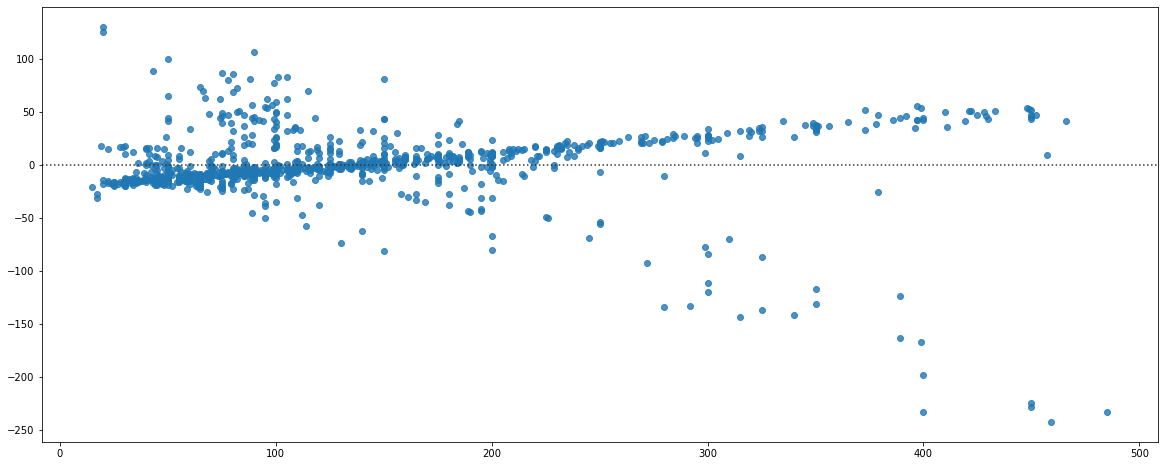

In [30]:
plt.figure(figsize=(20,8))
sns.residplot(x=y_test[:1000],y=y_pred[:1000])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
        4.0000e+00, 4.0000e+00, 7.0000e+00, 1.0000e+01, 8.0000e+00,
        1.1000e+01, 8.0000e+00, 7.0000e+00, 7.0000e+00, 9.0000e+00,
        1.2000e+01, 1.1000e+01, 8.0000e+00, 5.0000e+00, 1.2000e+01,
        1.7000e+01, 1.7000e+01, 1.4000e+01, 2.3000e+01, 1.5000e+01,
        1.2000e+01, 2.7000e+01, 2.5000e+01, 2.3000e+01, 3.6000e+01,
        4.1000e+01, 3.3000e+01, 3.2000e+01, 4.1000e+01, 4.5000e+01,
        5.2000e+01, 4.6000e+01, 6.7000e+01, 6.9000e+01, 6.1000e+01,
        6.6000e+01, 7.5000e+01, 7.5000e+01, 1.2500e+02, 9.8000e+01,
        1.1300e+02, 1.4900e+02, 1.9200e+02, 2.0000e+02, 3.0100e+02,
        4.2700e+02, 6.0600e+02, 1.5830e+03, 1.1174e+04, 1.1240e+04,
        1.6300e+03, 8.7900e+02, 7.0100e+02, 5.9900e+02, 5.0000e+02,
        3.9700e+02, 3.2800e+02, 3.2100e+02, 2.53

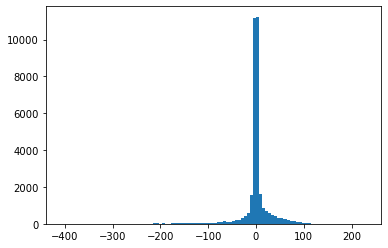

In [31]:
d=y_pred-y_test

plt.hist(d, bins=100)

Shows the most important features 

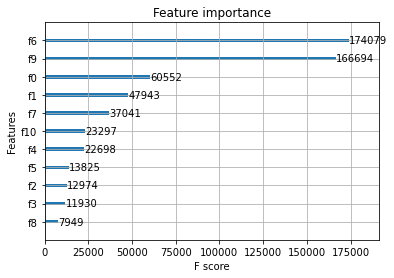

In [32]:
xgb.plot_importance(model, ax=plt.gca())
plt.show()

# Conclusion

### Findings

This study concluded that and XGBoost is the best model to run to predict the best rental property price.

### Recommendation

We recommend an XGBoost Because:
       
       1. It is more accurate than a Decision Tree
        
       2. The runtime is slightly longer, but it is worth it because the accuracy out-weighs the runtime of the model
       
If you follow these recommendations you will be able to find the most comditive price  to price your rental property at. This is maximize your profit by allowing your property to get book more at the highest possible price.

### Future Research

If this study were to continue it would be interesting to find a data set with information on cost to maintain and amount of days actaully rented. This information would give us access to a true profit value and could effect the out come of this model.

### Thank you for your time!